# Note for 02_train_rgb_finetuning.py

###  Import libaries

In [1]:
import os
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16 as VGG
from tensorflow.keras.applications.densenet import DenseNet201 as DenseNet
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

from image_functions import preprocessing_image_rgb

d:\Anaconda\envs\sate_3812\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


### Define path to training and validation data

In [2]:
# variables
path_to_split_datasets = "H:\Multi-Spectral-Satelite-Image-Classification\Dataset\Processed_Data"
use_vgg = True
batch_size = 32

# contruct path
path_to_home = os.path.expanduser("~")
path_to_split_datasets = path_to_split_datasets.replace("~", path_to_home)
path_to_train = os.path.join(path_to_split_datasets, "train")
path_to_validation = os.path.join(path_to_split_datasets, "validation")

### Determine number of classes from data

In [3]:
# get number of classes
sub_dirs = [sub_dir for sub_dir in os.listdir(path_to_train)
            if os.path.isdir(os.path.join(path_to_train, sub_dir))]
num_classes = len(sub_dirs)

## Transfer-learning 

### 1. Pretrained network model without top layers

In [4]:
# parameters for CNN
if use_vgg:
    base_model = VGG(include_top=False,
                     weights='imagenet',
                     input_shape=(64, 64, 3))
else:
    base_model = DenseNet(include_top=False,
                          weights='imagenet',
                          input_shape=(64, 64, 3))

### 2. Define new top layers

In [5]:
# add a global spatial average pooling layer
top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
# or just flatten the layers
#    top_model = Flatten()(top_model)
# let's add a fully-connected layer
if use_vgg:
    # only in VGG19 a fully connected nn is added for classfication
    # DenseNet tends to overfitting if using additionally dense layers
    top_model = Dense(2048, activation='relu')(top_model)
    top_model = Dense(2048, activation='relu')(top_model)
# and a logistic layer
predictions = Dense(num_classes, activation='softmax')(top_model)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# print network structure
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)      

### 3. Define data augmentation

In [6]:
# defining ImageDataGenerators
# ... initialization for training
train_datagen = ImageDataGenerator(fill_mode="reflect",
                                   rotation_range=45,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   preprocessing_function=preprocessing_image_rgb)
# ... initialization for validation
test_datagen = ImageDataGenerator(preprocessing_function=preprocessing_image_rgb)
# ... definition for training
train_generator = train_datagen.flow_from_directory(path_to_train,
                                                    target_size=(64, 64),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')
# just for information
class_indices = train_generator.class_indices
print(class_indices)

# ... definition for validation
validation_generator = test_datagen.flow_from_directory(path_to_validation,
                                                        target_size=(64, 64),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')



Found 1494 images belonging to 3 classes.
{'building': 0, 'farmland': 1, 'forest': 2}
Found 639 images belonging to 3 classes.


### 4. Define callbacks

In [7]:
# generate callback to save best model w.r.t val_categorical_accuracy
if use_vgg:
    file_name = "vgg"
else:
    file_name = "dense"

checkpointer = ModelCheckpoint("H:\Multi-Spectral-Satelite-Image-Classification\Temp_Models\M_" + file_name +
                               "_rgb_transfer_init." +
                               "{epoch:02d}-{val_categorical_accuracy:.3f}." +
                               "hdf5",
                               monitor='val_categorical_accuracy',
                               verbose=1,
                               save_best_only=True,
                               mode='max')

earlystopper = EarlyStopping(monitor='val_categorical_accuracy',
                             patience=10,
                             mode='max',
                             restore_best_weights=True)

tensorboard = TensorBoard(log_dir='./logs', write_graph=True, 
                          write_images=True, update_freq='epoch')


### 5. Set base layers non trainable 

In [8]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adadelta', loss='categorical_crossentropy',
              metrics=['categorical_accuracy',"Precision","Recall","TruePositives","TrueNegatives", "FalsePositives", "FalseNegatives"])

### 6. Fit model (train new top layers)

In [9]:
history = model.fit(train_generator,
                    steps_per_epoch=32,
                    epochs=4,
                    callbacks=[checkpointer, earlystopper,
                               tensorboard],
                    validation_data=validation_generator,
                    validation_steps=4)
initial_epoch = len(history.history['loss'])

Epoch 1/4
 1/32 [..............................] - ETA: 0s - loss: 1.0988 - categorical_accuracy: 0.4375 - precision: 1.0000 - recall: 0.0312 - true_positives: 1.0000 - true_negatives: 64.0000 - false_positives: 0.0000e+00 - false_negatives: 31.0000WARNING:tensorflow:From d:\Anaconda\envs\sate_3812\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
32/32 [==============================] - ETA: 0s - loss: 1.0802 - categorical_accuracy: 0.5117 - precision: 0.5000 - recall: 9.7656e-04 - true_positives: 1.0000 - true_negatives: 2047.0000 - false_positives: 1.0000 - false_negatives: 1023.0000
Epoch 00001: val_categorical_accuracy improved from -inf to 0.57812, saving model to H:\Multi-Spectral-Satelite-Image-Classification\Temp_Models\M_vgg_rgb_transfer_init.01-0.578.hdf5
32/32 [==============================] -

### Plotting Accuracy Curve for new layer

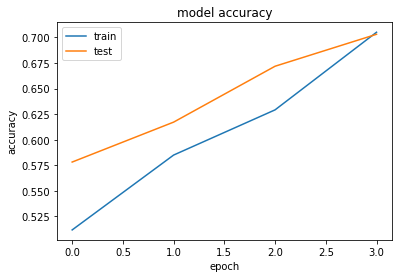

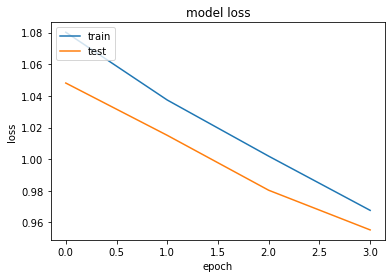

In [10]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 7. Setting base layers trainable

In [11]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
names = []
for i, layer in enumerate(model.layers):
    print([i, layer.name, layer.trainable])

if use_vgg:
    # we will freaze the first convolutional block and train all
    # remaining blocks, including top layers.
    for layer in model.layers[:4]:
        layer.trainable = False
    for layer in model.layers[4:]:
        layer.trainable = True
else:
    for layer in model.layers[:7]:
        layer.trainable = False
    for layer in model.layers[7:]:
        layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy',"Precision","Recall","TruePositives","TrueNegatives", "FalsePositives", "FalseNegatives"])

[0, 'input_1', False]
[1, 'block1_conv1', False]
[2, 'block1_conv2', False]
[3, 'block1_pool', False]
[4, 'block2_conv1', False]
[5, 'block2_conv2', False]
[6, 'block2_pool', False]
[7, 'block3_conv1', False]
[8, 'block3_conv2', False]
[9, 'block3_conv3', False]
[10, 'block3_pool', False]
[11, 'block4_conv1', False]
[12, 'block4_conv2', False]
[13, 'block4_conv3', False]
[14, 'block4_pool', False]
[15, 'block5_conv1', False]
[16, 'block5_conv2', False]
[17, 'block5_conv3', False]
[18, 'block5_pool', False]
[19, 'global_average_pooling2d', True]
[20, 'dense', True]
[21, 'dense_1', True]
[22, 'dense_2', True]


### 8. Fit model (fine-tune base and top layers)

In [12]:
# generate callback to save best model w.r.t val_categorical_accuracy
if use_vgg:
    file_name = "vgg"
else:
    file_name = "dense"
checkpointer = ModelCheckpoint(r"H:\Multi-Spectral-Satelite-Image-Classification\Temp_Models\M_" + file_name +
                               "_rgb_transfer_final." +
                               "{epoch:02d}-{val_categorical_accuracy:.3f}" +
                               ".hdf5",
                               monitor='val_categorical_accuracy',
                               verbose=1,
                               save_best_only=True,
                               mode='max')
earlystopper = EarlyStopping(monitor='val_categorical_accuracy',
                             patience=50,
                             mode='max')
history = model.fit(train_generator,
          steps_per_epoch=32,
          epochs=initial_epoch+4,
          callbacks=[checkpointer, earlystopper, tensorboard],
          validation_data=validation_generator,
          validation_steps=4,
          initial_epoch=initial_epoch)

Epoch 5/8
32/32 [==============================] - ETA: 0s - loss: 0.8747 - categorical_accuracy: 0.8232 - precision: 0.9944 - recall: 0.1729 - true_positives: 177.0000 - true_negatives: 2047.0000 - false_positives: 1.0000 - false_negatives: 847.0000
Epoch 00005: val_categorical_accuracy improved from -inf to 0.82812, saving model to H:\Multi-Spectral-Satelite-Image-Classification\Temp_Models\M_vgg_rgb_transfer_final.05-0.828.hdf5
32/32 [==============================] - 63s 2s/step - loss: 0.8747 - categorical_accuracy: 0.8232 - precision: 0.9944 - recall: 0.1729 - true_positives: 177.0000 - true_negatives: 2047.0000 - false_positives: 1.0000 - false_negatives: 847.0000 - val_loss: 0.7613 - val_categorical_accuracy: 0.8281 - val_precision: 0.9811 - val_recall: 0.4062 - val_true_positives: 52.0000 - val_true_negatives: 255.0000 - val_false_positives: 1.0000 - val_false_negatives: 76.0000
Epoch 6/8
32/32 [==============================] - ETA: 0s - loss: 0.5975 - categorical_accuracy: 0

### Ploting Accuracy Curve Fine-tuned Model

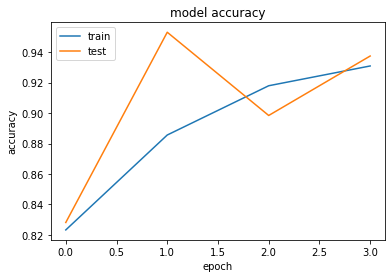

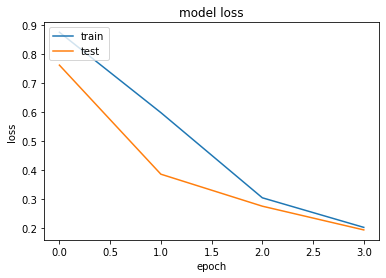

In [13]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
